If you are using Colab you will get the following Error.

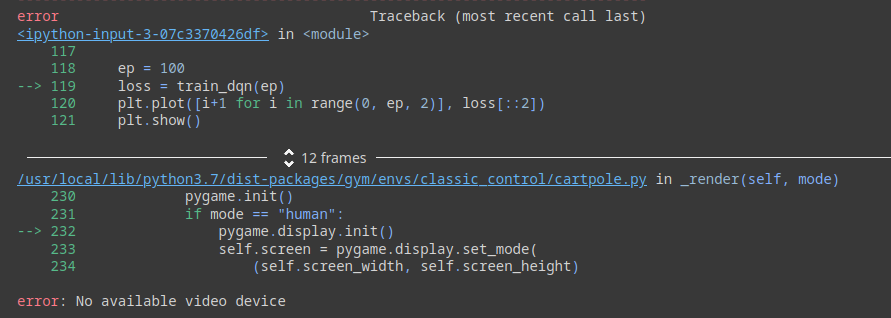

Use the first cell to suppress  pygame error which says No availabe video Device.

In [ ]:
!pip install pygame
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.7 MB/s 
pygame 2.1.2 (SDL 2.0.16, Python 3.7.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


<Surface(640x480x32 SW)>

Importing Required Libraries and Setting up `Gym` environment 

In [ ]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

'''We make an environment instance with this command'''
env = gym.make('CartPole-v0')
'''sets the seed for this environment's rnadom number generator'''
'''this env.seed is not available in gym 0.26.2 anymore you need to have gym 0.25 version'''
env.seed(0)
'''to set seed for numpys rand num generator'''
np.random.seed(0)


/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

DQN is a model that takes in the state and outputs the Q values for each action
Q values are the expected reward for taking a particular action in a particular state.
We start with a `class DQN`.

*   The model is a simple feed forward newural network with two hidden layers 24 nodes each.
*   The input shape is the state_space which is 4 in our case.
*   The output shape is the action_space which is 2 in this case.
*   The model uses a rectigied linear unit(ReLU) activation fun for all hidden layers

*   The output layer uses a linear activation function to output the action values.
*   We use mse loss function and Adam optimizer

In [ ]:
class DQN:
    def __init__(self, action_space, state_space):

        '''Setting up number of possible actions and states '''
        self.action_space = action_space
        self.state_space = state_space
      
        '''setting the exporation rate and discount rate'''
      
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
      
        '''defining the rate with which we decrease the exploration rate'''
        self.epsilon_decay = .995
        self.learning_rate = 0.001
      
        '''stores the prev states,actions,rewards and next state'''
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model


    def remember(self, state, action, reward, next_state, done):
      '''The memory buffer will store a list of tuples which will contain
      the state,actin,reward,next_state and done value for each transition'''

      self.memory.append((state, action, reward, next_state, done))

      '''The remember function will append the transition all the parameters to the
        memory buffer.'''


    def act(self, state):


        '''The epsilon value is used to determine whether to choose a random action
        or an action with the highest Q values'''
      
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
      
            '''The act function is use to choose an action based on the sate of the environment'''
      
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    

    def replay(self):
      
        '''to check if w ehave enough samples in out memory'''
      
        if len(self.memory) < self.batch_size:
            return
        '''We take a random sample because we don't want to use the same data over and over again'''
      
        minibatch = random.sample(self.memory, self.batch_size)
        '''We need first element in the minibatch to predict the Q values'''
      
        states = np.array([i[0] for i in minibatch])  
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])
      
        '''we use squeeze to remove the extra dimension as states has shape (64,1,4) and we need it to be (64,4)
            Same for next_states'''
      
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        '''The target fot the action that was actially taken is the reward + the discounted , it predircts return from the next state
            We do this to ensure that the network does not change the weights fo rthe action that were not taken
            The done vector is used to remove the discounted from predicted '''
      
        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
      
        '''Select the values from target_full, where the first dimension is specified the by the values in the 1D array IND and the 
            Second dimension is specified by the values in the !D array '''
      
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
      
        '''We decrease the epsilon value to increase the exploration '''
      
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [ ]:
def train_dqn(episode):

    loss = []

    #Creating an instance of class DQN
    
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    
    for e in range(episode): #We define number of episodes we want out agent to train for
    
        state = env.reset()  #to make the environment compatible with the NN input
    
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
    
        for i in range(max_steps): #defining number of steps we want agent to be trained 
    
            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {},steps: {}".format(e, episode, score, i))
                break
        loss.append(score)
    return loss

In [ ]:
def random_policy(episode, step):
    
    '''This function is to test the performance of a a random action at each step'''
    
    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")

After nearly 60 episodes the scores stays 200 :) We can see how it performs for 70 episodes below :)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
episode: 26/70, score: 40.0,steps: 39
1/1 [==============================] - 0s 16ms/step
episode: 27/70, score: 40.0,steps: 39
1/1 [==============================] - 0s 24ms/step
episode: 28/70, score: 48.0,steps: 47
1/1 [==============================] - 0s 18ms/step
episode: 29/70, score: 66.0,steps: 65
1/1 [==============================] - 0s 20ms/step
episode: 30/70, score: 83.0,steps: 82
1/1 [==============================] - 0s 17ms/step
episode: 31/70, score: 55.0,steps: 54
1/1 [==============================] - 0s 18ms/step
episode: 32/70, score: 100.0,steps: 99
1/1 [==============================] - 0s 16ms/step
episode: 33/70, score: 99.0,steps: 98
1/1 [==============================] - 0s 16ms/step
episode: 34/70, score: 74.0,steps: 73
1/1 [==============================] - 0s 18ms/step
episode: 35/70, score: 83.0,steps: 82
1/1 [==============================] - 0s 17ms/s

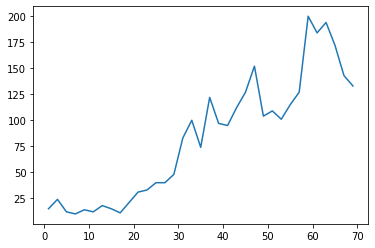

In [ ]:
if __name__ == '__main__':
    
    ep = 70
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()

If you are training locally your environment will look like this

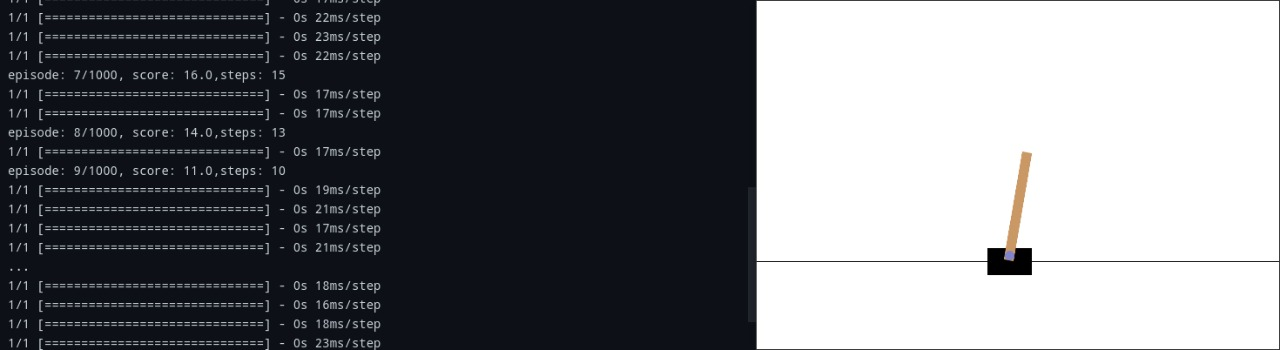

Don't run the First Cell if you are going to run it locally else you won't see the game environment :)